# How to manipulate & plot DNF `countme` data with `pandas`!

Hello! This is a Jupyter notebook that demonstrates how to use the `pandas` python library to mess around with the DNF `countme` data.



## Table of contents

1. [Setup](#setup)
2. [Load / parse CSV data](#load_csv)
3. [Indexing and slicing](#index_slice)
4. [Grouping data and counting hosts](#group_count_hosts)
5. [More fun with `unstack()` and `pivot_table()`](#unstack_pivot)
6. [Actually making charts & graphs](#plot)

## Setup <a name="setup">

I should probably have some instructions here about how to install `pandas` and load this notebook for interactive use... oh well, there's always cut-and-paste.
    
Anyway, here's your usual python imports and some constants that we'll use through the rest of the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# BASEARCHES is  list of all $basearch values known to DNF, generated with:
#     import dnf
#     BASEARCHES = set(dnf.rpm._BASEARCH_MAP.values())
# then grouped by current status and ordered by frequency.
BASEARCHES = [
    # F32 primary arches
    'x86_64', 'aarch64', 'armhfp',
    # F32 secondary arches
    'ppc64le', 's390x', 'mipsel', 'mips64el', 'riscv64',
    # Historical Fedora arches
    'i386', 'ia64', 'arm', 'ppc', 'ppc64', 's390', 'sparc'
    # Other arches DNF knows about, but (afaik) we've never built Fedora for
    'alpha', 'mips', 'mips64', 'riscv32', 'riscv128', 'sh3', 'sh4',
    # This could be a valid repo_arch (but not os_arch!)
    'noarch'
]

# SYS_AGES is an array/index of timedeltas that correspond to sys_age values.
# sys_age=1 -> [0w, 2w), sys_age=2 -> [2w, 5w), etc.
# (Defined in COUNTME_BUCKETS in libdnf/libdnf/repo/Repo.cpp)
SYS_AGES = pd.to_timedelta(['0w', '2w', '5w', '25w'])

In [3]:
# Column names!
# It's convenient to have the column names split up by their function, so:

# os_id_cols identify the OS itself
os_id_cols = ['os_name', 'os_version', 'os_variant']

# sys_id_cols are properties of the client system
sys_id_cols = ['os_arch', 'sys_age']

# repo_id_cols identify the requested repo, not the host itself
repo_id_cols = ['repo_tag', 'repo_arch']

# id_cols represents all the identifier/index columns.
id_cols = os_id_cols + sys_id_cols + repo_id_cols

# host_id_cols is the unique identifier for the host, or: "everything but the repo"
host_id_cols = [c for c in id_cols if c not in repo_id_cols]

## Load / parse CSV data <a name="load_csv">
   

In [4]:
# Read the CSV data and do a little data type massaging.

# Here's a couple pre-defined categorical types we'll use.
# Any arch or age value outside these values should be considered an error.
arch_cat_dtype = pd.CategoricalDtype(categories=BASEARCHES)
age_cat_dtype = pd.CategoricalDtype(categories=[1,2,3,4], ordered=True)

# Okay, actually read the CSV, parsing dates and setting data types as we go.
totals = pd.read_csv("../totals.csv",
    parse_dates=['week_start', 'week_end'],
    dtype={
        'os_name':    'category',
        'os_version': 'category',
        'os_variant': 'category',
        'repo_tag':   'category',
        'os_arch':    arch_cat_dtype,
        'repo_arch':  arch_cat_dtype,
        'sys_age':    age_cat_dtype,
        # NOTE: change to int64 when we get >= 4 billion users per week :P
        'hits':       np.int32, 
    }
)

# This is just here to show the contents of 'totals' in the Jupyter notebook.
totals

,week_start,week_end,hits,os_name,os_version,os_variant,os_arch,sys_age,repo_tag,repo_arch
0,2020-02-10,2020-02-16,2,Fedora,31,generic,x86_64,3,fedora-modular-31,x86_64
1,2020-02-10,2020-02-16,2,Fedora,31,generic,x86_64,3,updates-released-f31,x86_64
2,2020-02-10,2020-02-16,1,Fedora,31,workstation,x86_64,3,updates-released-modular-f31,x86_64
3,2020-02-10,2020-02-16,2,Fedora,31,workstation,x86_64,3,fedora-31,x86_64
4,2020-02-10,2020-02-16,2,Fedora,31,generic,x86_64,3,updates-released-modular-f31,x86_64
...,...,...,...,...,...,...,...,...,...,...
37301,2020-10-26,2020-11-01,1,Fedora,34,workstation,x86_64,4,updates-released-modular-f34,x86_64
37302,2020-10-26,2020-11-01,1,Fedora,32,container,aarch64,1,updates-released-modular-f33,aarch64
37303,2020-10-26,2020-11-01,1,Fedora,32,container,aarch64,1,updates-released-f33,aarch64
37304,2020-10-26,2020-11-01,1,CentOS Linux,8,generic,x86_64,1,testing-epel8,x86_64


In [5]:
# Here's what values we saw for os_name, os_version, and os_variant..
for col in os_id_cols:
    print(f'{col}: {totals[col].cat.categories}')

os_name: Index(['Broken Fedora', 'CentOS Linux', 'CentOS Stream', 'Centos',
       'Clear Linux OS', 'DeepFake', 'FSystem', 'Fan-Linux OS', 'Fedora',
       'Fedora Raven', 'Fedora Raven Edition', 'Fedora Remix for WSL',
       'Fedora-Android', 'Fedoraa', 'Franky', 'GNOME OS',
       'GSBvBIOS_NDA_10P.4.4', 'Generic', 'Hongkong Linux', 'Ideco UTM',
       'Ideco utm', 'JambulaOS', 'Keepod PRV', 'Lemonade OS', 'Liri OS',
       'Magic', 'Mahan', 'NST', 'Novos', 'Oracle Linux Server', 'OsoLinux',
       'PetalOS', 'Pingus', 'Private Void Enterprise Linux',
       'Red Hat Enterprise Linux', 'Red Hat Enterprise Linux Server',
       'Red Hat Enterprise Linux Workstation', 'RedHat', 'SONICast',
       'SereneLinux', 'SuperRed', 'Top Hat', 'UXCloud', 'Ubuntu', 'VirtOS',
       'WJSN Linux', 'Waders', 'Wick', 'Will Woods Fan Club',
       'Will Woods: secret vampire?', 'XF', 'brynux', 'idesk System',
       'ilo Pepola'],
      dtype='object')
os_version: Index(['0.10.0', '1', '10000', '11'

## Indexing and slicing <a name="index_slice">

In [6]:
# Instead of having 'week_start'/'week_end' as individual columns, make a
# periodic index where each 'week' item covers the entire week's timespan.
# (W-SUN means "week ends on Sunday")
week_index = pd.PeriodIndex(data=totals['week_start'], name='week', freq='W-SUN')

# Add that index and drop `week_start` / `week_end`
week_totals = totals.set_index(week_index).drop(columns=['week_start', 'week_end'])

# Let's have a look!
week_totals

,hits,os_name,os_version,os_variant,os_arch,sys_age,repo_tag,repo_arch
week,,,,,,,,
2020-02-10/2020-02-16,2,Fedora,31,generic,x86_64,3,fedora-modular-31,x86_64
2020-02-10/2020-02-16,2,Fedora,31,generic,x86_64,3,updates-released-f31,x86_64
2020-02-10/2020-02-16,1,Fedora,31,workstation,x86_64,3,updates-released-modular-f31,x86_64
2020-02-10/2020-02-16,2,Fedora,31,workstation,x86_64,3,fedora-31,x86_64
2020-02-10/2020-02-16,2,Fedora,31,generic,x86_64,3,updates-released-modular-f31,x86_64
...,...,...,...,...,...,...,...,...
2020-10-26/2020-11-01,1,Fedora,34,workstation,x86_64,4,updates-released-modular-f34,x86_64
2020-10-26/2020-11-01,1,Fedora,32,container,aarch64,1,updates-released-modular-f33,aarch64
2020-10-26/2020-11-01,1,Fedora,32,container,aarch64,1,updates-released-f33,aarch64


In [7]:
# Having a PeriodicIndex is handy for a bunch of reasons.
# For example - you can use arbitrary dates/timestamps and pandas will figure out
# which week that belongs to. Like so:
week_totals.loc['July 4 2020']

,hits,os_name,os_version,os_variant,os_arch,sys_age,repo_tag,repo_arch
week,,,,,,,,
2020-06-29/2020-07-05,27033,Fedora,32,workstation,x86_64,1,fedora-modular-32,x86_64
2020-06-29/2020-07-05,19872,Fedora,32,workstation,x86_64,2,updates-released-f32,x86_64
2020-06-29/2020-07-05,28819,Fedora,32,workstation,x86_64,1,updates-released-modular-f32,x86_64
2020-06-29/2020-07-05,29099,Fedora,32,workstation,x86_64,1,updates-released-f32,x86_64
2020-06-29/2020-07-05,26896,Fedora,32,workstation,x86_64,1,fedora-32,x86_64
...,...,...,...,...,...,...,...,...
2020-06-29/2020-07-05,1,Fedora,33,container,x86_64,2,updates-testing-f33,x86_64
2020-06-29/2020-07-05,1,Generic,32,generic,x86_64,1,updates-released-modular-f31,x86_64
2020-06-29/2020-07-05,1,Fedora,31,workstation,x86_64,1,fedora-32,x86_64


In [8]:
# Or if you just want the most recent week's data:
last_week = week_totals.index.max()
week_totals.loc[last_week]

,hits,os_name,os_version,os_variant,os_arch,sys_age,repo_tag,repo_arch
week,,,,,,,,
2020-10-26/2020-11-01,19511,Fedora,32,generic,x86_64,3,fedora-32,x86_64
2020-10-26/2020-11-01,15815,Fedora,32,generic,x86_64,1,updates-released-modular-f32,x86_64
2020-10-26/2020-11-01,25591,Fedora,32,generic,x86_64,3,updates-released-f32,x86_64
2020-10-26/2020-11-01,6262,Fedora,32,cloud,x86_64,3,fedora-modular-32,x86_64
2020-10-26/2020-11-01,15688,Fedora,32,workstation,x86_64,1,fedora-32,x86_64
...,...,...,...,...,...,...,...,...
2020-10-26/2020-11-01,1,Fedora,34,workstation,x86_64,4,updates-released-modular-f34,x86_64
2020-10-26/2020-11-01,1,Fedora,32,container,aarch64,1,updates-released-modular-f33,aarch64
2020-10-26/2020-11-01,1,Fedora,32,container,aarch64,1,updates-released-f33,aarch64


In [9]:
# In practice, we want to index over time and all 'identifier' columns:
idx_totals = week_totals.set_index(id_cols, append=True)
idx_totals

hits
week                  os_name      os_version os_variant  os_arch sys_age repo_tag                     repo_arch      
2020-02-10/2020-02-16 Fedora       31         generic     x86_64  3       fedora-modular-31            x86_64        2
                                                                          updates-released-f31         x86_64        2
                                              workstation x86_64  3       updates-released-modular-f31 x86_64        1
                                                                          fedora-31                    x86_64        2
                                              generic     x86_64  3       updates-released-modular-f31 x86_64        2
...                                                                                                                ...
2020-10-26/2020-11-01 Fedora       34         workstation x86_64  4       updates-released-modular-f34 x86_64        1
                                   32         container   aarch64 1       updates-released-modular-f33 aarch64       1
                                                                          updates-released-f33         aarch64       1
                      CentOS Linux 8          generic     x86_64  1       testing-epel8                x86_64        1
                      Fedora       34         workstation x86_64  1       updates-released-f33         x86_64        1

[37306 rows x 1 columns]

In [10]:
# We can now slice this data in all kinda of fun ways to give us only the bits we're interested in.
# Let's see Fedora 31 x86_64 systems for one particular week in July 2020.
# (There's a bunch of different ways to slice - see the pandas docs for more info)
All = slice(None)
idx_totals.loc[('2020-07-13', 'Fedora', '31', All, 'x86_64'), All]

hits
week                  os_name os_version os_variant  os_arch sys_age repo_tag                     repo_arch      
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  3       fedora-modular-31            x86_64        3
                                                                     updates-released-modular-f31 x86_64        3
                                                                     updates-released-f31         x86_64        3
                                                             1       updates-released-modular-f31 x86_64        2
                                                                     updates-released-f31         x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             3       fedora-31                    x86_64        3
                                                             4       fedora-31                    x86_64        1
                                                             1       fedora-modular-31            x86_64        1
                                                             4       updates-released-modular-f31 x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                         workstation x86_64  2       updates-released-modular-f32 x86_64        1
                                                                     fedora-modular-32            x86_64        1
                                                                     updates-released-f32         x86_64        1
                                                                     fedora-32                    x86_64        1
                                                             1       fedora-32                    x86_64        2
                                         generic     x86_64  2       fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                                                     updates-released-modular-f31 x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             1       fedora-modular-32            x86_64        1
                                         workstation x86_64  2       updates-released-f31         x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     fedora-31                    x86_64        1
                                         generic     x86_64  3       updates-testing-modular-f31  x86_64        1

In [11]:
# We can save the "slicer" itself and reuse it later:
lil_slice = ('2020-07-13', 'Fedora', '31', All, 'x86_64'), All
idx_totals.loc[lil_slice]

hits
week                  os_name os_version os_variant  os_arch sys_age repo_tag                     repo_arch      
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  3       fedora-modular-31            x86_64        3
                                                                     updates-released-modular-f31 x86_64        3
                                                                     updates-released-f31         x86_64        3
                                                             1       updates-released-modular-f31 x86_64        2
                                                                     updates-released-f31         x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             3       fedora-31                    x86_64        3
                                                             4       fedora-31                    x86_64        1
                                                             1       fedora-modular-31            x86_64        1
                                                             4       updates-released-modular-f31 x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                         workstation x86_64  2       updates-released-modular-f32 x86_64        1
                                                                     fedora-modular-32            x86_64        1
                                                                     updates-released-f32         x86_64        1
                                                                     fedora-32                    x86_64        1
                                                             1       fedora-32                    x86_64        2
                                         generic     x86_64  2       fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                                                     updates-released-modular-f31 x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             1       fedora-modular-32            x86_64        1
                                         workstation x86_64  2       updates-released-f31         x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     fedora-31                    x86_64        1
                                         generic     x86_64  3       updates-testing-modular-f31  x86_64        1

In [12]:
# Alternate method: using the cross-section function .xs() can be clearer.
idx_totals.xs(level=('week', 'os_name', 'os_version', 'os_arch'),
              key=('2020-07-13', 'Fedora', '31', 'x86_64'),
              drop_level=False)

hits
week                  os_name os_version os_variant  os_arch sys_age repo_tag                     repo_arch      
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  3       fedora-modular-31            x86_64        3
                                                                     updates-released-modular-f31 x86_64        3
                                                                     updates-released-f31         x86_64        3
                                                             1       updates-released-modular-f31 x86_64        2
                                                                     updates-released-f31         x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             3       fedora-31                    x86_64        3
                                                             4       fedora-31                    x86_64        1
                                                             1       fedora-modular-31            x86_64        1
                                                             4       updates-released-modular-f31 x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                         workstation x86_64  2       updates-released-modular-f32 x86_64        1
                                                                     fedora-modular-32            x86_64        1
                                                                     updates-released-f32         x86_64        1
                                                                     fedora-32                    x86_64        1
                                                             1       fedora-32                    x86_64        2
                                         generic     x86_64  2       fedora-modular-31            x86_64        1
                                                                     updates-released-f31         x86_64        1
                                                                     updates-released-modular-f31 x86_64        1
                                                                     fedora-31                    x86_64        1
                                                             1       fedora-modular-32            x86_64        1
                                         workstation x86_64  2       updates-released-f31         x86_64        1
                                                                     fedora-modular-31            x86_64        1
                                                                     fedora-31                    x86_64        1
                                         generic     x86_64  3       updates-testing-modular-f31  x86_64        1

## Grouping data and counting hosts <a name="group_count_hosts">

Okay, enough introductions. Here's the tricky part: counting _hosts_ rather than hits. See below for a detailed explanation of how this works, but for the impatient:
    
Each client system should send a `countme=N` once per week **per repo**, so our best approximation for the number of unique hosts is the **max number of hits across repos for each group of hosts**. 
       
You can calculate this in pandas like so:

In [13]:
host_totals = (
    week_totals
    .groupby(['week']+host_id_cols, observed=True)
    .agg(hosts=('hits', 'max'), hits=('hits', 'sum'))
)

# We've now got hosts & hits counted for each host type:
host_totals.loc[lil_slice]

hosts  \
week                  os_name os_version os_variant  os_arch sys_age          
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1            2   
                                                             2            1   
                                                             3            3   
                                                             4            1   
                                         workstation x86_64  1            2   
                                                             2            1   

                                                                      hits  
week                  os_name os_version os_variant  os_arch sys_age        
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1           6  
                                                             2           4  
                                                             3          13  
                                                             4           4  
                                         workstation x86_64  1           2  
                                                             2           7

### Counting hosts, explained

So here's a demonstration of why we count hosts this way.

Each host is supposed to send a maximum of one `countme=N` **per repo** per week. They can (and most do) hit multiple repos per week.

To illustrate that, let's take the same slice as the previous section, but change the axes around
so we have columns for each `repo_tag` and `repo_arch`.

In [14]:
# NOTE: we use fill_value=0 because otherwise pandas puts NaNs in the empty spaces
idx_totals.loc[lil_slice].unstack(repo_id_cols, fill_value=0)

hits  \
repo_tag                                                             fedora-modular-31   
repo_arch                                                                       x86_64   
week                  os_name os_version os_variant  os_arch sys_age                     
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1                       1   
                                                             2                       1   
                                                             3                       3   
                                                             4                       1   
                                         workstation x86_64  1                       0   
                                                             2                       1   

                                                                                                   \
repo_tag                                                             updates-released-modular-f31   
repo_arch                                                                                  x86_64   
week                  os_name os_version os_variant  os_arch sys_age                                
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1                                  2   
                                                             2                                  1   
                                                             3                                  3   
                                                             4                                  1   
                                         workstation x86_64  1                                  0   
                                                             2                                  0   

                                                                                           \
repo_tag                                                             updates-released-f31   
repo_arch                                                                          x86_64   
week                  os_name os_version os_variant  os_arch sys_age                        
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1                          1   
                                                             2                          1   
                                                             3                          3   
                                                             4                          1   
                                         workstation x86_64  1                          0   
                                                             2                          1   

                                                                                \
repo_tag                                                             fedora-31   
repo_arch                                                               x86_64   
week                  os_name os_version os_variant  os_arch sys_age             
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1               1   
                                                             2               1   
                                                             3               3   
                                                             4               1   
                                         workstation x86_64  1               0   
                                                             2               1   

                                                                                                   \
repo_tag                                                             updates-released-modular-f32   
repo_arch                                                                                  x86_64   
week                  os_name os_version os_variant  os_arch sys_age                                
2020-07-13/202

In [15]:
# Once again, since each unique client system can hit any combination of repos per week,
# our best guess at how many systems there are is the max() value of each row.
# Conveniently, the pivot_table() function is designed just for this kind of thing!
(
    idx_totals.loc[lil_slice]
    .pivot_table(index=['week']+host_id_cols, aggfunc='max')
    .rename(columns={'hits':'hosts'})
)

hosts
week                  os_name os_version os_variant  os_arch sys_age       
2020-07-13/2020-07-19 Fedora  31         generic     x86_64  1            2
                                                             2            1
                                                             3            3
                                                             4            1
                                         workstation x86_64  1            2
                                                             2            1

In [16]:
# This means we could also use pivot_table() to generate host_totals, like so:
(
    week_totals
    .pivot_table(values='hits',
                 index=['week']+host_id_cols,
                 observed=True,
                 aggfunc=('sum', 'max'))
    .rename(columns={'sum':'hits', 'max':'hosts'})

# ..and just to prove you get the same results this way:
).equals(host_totals)

True

## More fun with `unstack()` and `pivot_table()` <a name="unstack_pivot">

In [17]:
# Here's a chart showing last week's unique hosts,
# by arch and system age:
(
    host_totals
    .loc[last_week]
    .unstack('os_arch', fill_value=0)
    .unstack('sys_age', fill_value=0)
)

hosts                       \
os_arch                                     x86_64                        
sys_age                                          1      2      3      4   
os_name              os_version os_variant                                
Fedora               31         generic         14      0     13      1   
                                workstation      1      0      2      1   
                     32         generic      21940   3593  25591   5886   
                                workstation  16641  13369  77007  27017   
                                container     8477    547   1352    123   
...                                            ...    ...    ...    ...   
CentOS Stream        8          generic          4      0      0      0   
Fedora Raven Edition 32         generic          1      0      0      0   
GSBvBIOS_NDA_10P.4.4 33         workstation      1      0      0      0   
Fedora Raven         33         generic          1      0      0      0   
Oracle Linux Server  8.2        server           1      0      0      0   

                                                                           \
os_arch                                     ppc64le           aarch64       
sys_age                                           1  2   3  4       1   2   
os_name              os_version os_variant                                  
Fedora               31         generic           0  0   0  0       0   0   
                                workstation       0  0   0  0       0   0   
                     32         generic         240  2  71  3     233  46   
                                workstation       1  0   7  4      59  11   
                                container       122  1   2  0     142   5   
...                                             ... ..  .. ..     ...  ..   
CentOS Stream        8          generic           0  0   0  0       0   0   
Fedora Raven Edition 32         generic           0  0   0  0       0   0   
GSBvBIOS_NDA_10P.4.4 33         workstation       0  0   0  0       0   0   
Fedora Raven         33         generic           0  0   0  0       0   0   
Oracle Linux Server  8.2        server            0  0   0  0       0   0   

                                             ...  hits                        \
os_arch                                      ... s390x     arm          i386   
sys_age                                      ...     3   4   1  2  3  4    1   
os_name              os_version os_variant   ...                               
Fedora               31         generic      ...     0   0   0  0  0  0    0   
                                workstation  ...     0   0   0  0  0  0    0   
                     32         generic      ...    57  48   0  0  0  0    0   
                                workstation  ...     0   0   0  0  0  0    0   
                                container    ...     0   0   1  0  0  0    0   
...                                          ...   ...  ..  .. .. .. ..  ...   
CentOS Stream        8          generic      ...     0   0   0  0  0  0    0   
Fedora Raven Edition 32         generic      ...     0   0   0  0  0  0    0   
GSBvBIOS_NDA_10P.4.4 33         workstation  ...     0   0   0  0  0  0    0   
Fedora Raven         33         generic      ...     0   0   0  0  0  0    0   
Oracle Linux Server  8.2        server       ...     0   0   0  0  0  0    0   

                                                      
os_arch                                               
sys_age                                      2  3  4  
os_name              os_version os_variant            
Fedora               31         generic      0  0  0  
                                workstation  0  0  0  
                     32         generic      0  0  0  
                                workstation  0  0  0  
                                container    0  0  0  
...                                         .. .. ..  
CentOS Strea

In [18]:
# Another way of showing the same data.
# Note that pivot_table removes empty columns with observed=True.
(
    host_totals
    .loc[last_week]
    .pivot_table(
        values='hosts',
        index=os_id_cols,
        columns=sys_id_cols,
        fill_value=0,
        observed=True
    )
)

os_arch                                     x86_64                       \
sys_age                                          1      2      3      4   
os_name              os_version os_variant                                
Fedora               31         generic         14      0     13      1   
                                workstation      1      0      2      1   
                     32         generic      21940   3593  25591   5886   
                                workstation  16641  13369  77007  27017   
                                container     8477    547   1352    123   
...                                            ...    ...    ...    ...   
CentOS Stream        8          generic          4      0      0      0   
Fedora Raven Edition 32         generic          1      0      0      0   
GSBvBIOS_NDA_10P.4.4 33         workstation      1      0      0      0   
Fedora Raven         33         generic          1      0      0      0   
Oracle Linux Server  8.2        server           1      0      0      0   

os_arch                                     aarch64              armhfp      \
sys_age                                           1   2    3   4      1   2   
os_name              os_version os_variant                                    
Fedora               31         generic           0   0    0   0      0   0   
                                workstation       0   0    0   0      0   0   
                     32         generic         233  46  246  88     28  22   
                                workstation      59  11   66  15     10   0   
                                container       142   5   20   0      1   0   
...                                             ...  ..  ...  ..    ...  ..   
CentOS Stream        8          generic           0   0    0   0      0   0   
Fedora Raven Edition 32         generic           0   0    0   0      0   0   
GSBvBIOS_NDA_10P.4.4 33         workstation       0   0    0   0      0   0   
Fedora Raven         33         generic           0   0    0   0      0   0   
Oracle Linux Server  8.2        server            0   0    0   0      0   0   

os_arch                                      ... ppc64le           s390x     \
sys_age                                      ...       1  2   3  4     1  2   
os_name              os_version os_variant   ...                              
Fedora               31         generic      ...       0  0   0  0     0  0   
                                workstation  ...       0  0   0  0     0  0   
                     32         generic      ...     240  2  71  3    45  5   
                                workstation  ...       1  0   7  4     0  0   
                                container    ...     122  1   2  0    72  0   
...                                          ...     ... ..  .. ..   ... ..   
CentOS Stream        8          generic      ...       0  0   0  0     0  0   
Fedora Raven Edition 32         generic      ...       0  0   0  0     0  0   
GSBvBIOS_NDA_10P.4.4 33         workstation  ...       0  0   0  0     0  0   
Fedora Raven         33         generic      ...       0  0   0  0     0  0   
Oracle Linux Server  8.2        server       ...       0  0   0  0     0  0   

os_arch                                             i386 arm  
sys_age                                       3   4    3   1  
os_name              os_version os_variant                    
Fedora               31         generic       0   0    0   0  
                                workstation   0   0    0   0  
                     32         generic      16  12    0   0  
                                workstation   0   0    0   0  
                                container     0   0    0   1  
...                                          ..  ..  ...  ..  
CentOS Stream        8          generic       0   0    0   0  
Fedora Raven Edition 32         generic       0   0    0   0  
GSBvBIOS_NDA_10P.4.4 33         workstatio

## Actually making charts & graphs <a name="plot">

<AxesSubplot:xlabel='week'>

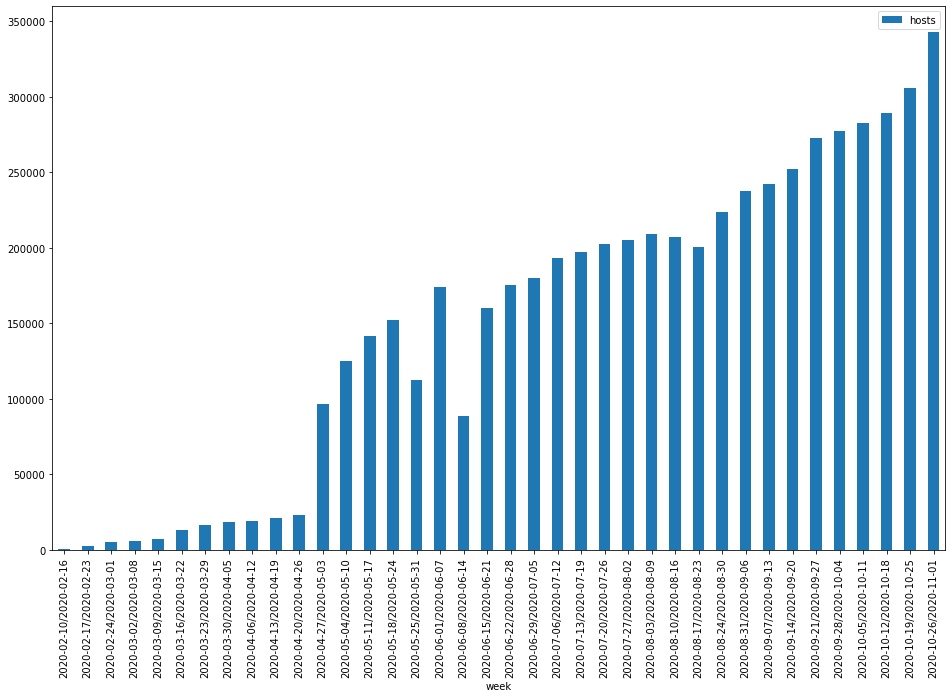

In [19]:
# Okay, let's make some graphs!
# pivot_table makes it pretty straightforward to get the data you want to plot:
# `index` gives the x-axis, `values` gives the values, and `aggfunc` names the
# function to use to collapse all the other index items.
# It's simpler than it sounds.
# Let's say you wanted a bar plot of the total number of hosts by week:
(
    host_totals
    .pivot_table(index='week', values='hosts', aggfunc='sum')
    .plot.bar(stacked=True, figsize=(16,10))
)

<AxesSubplot:xlabel='week'>

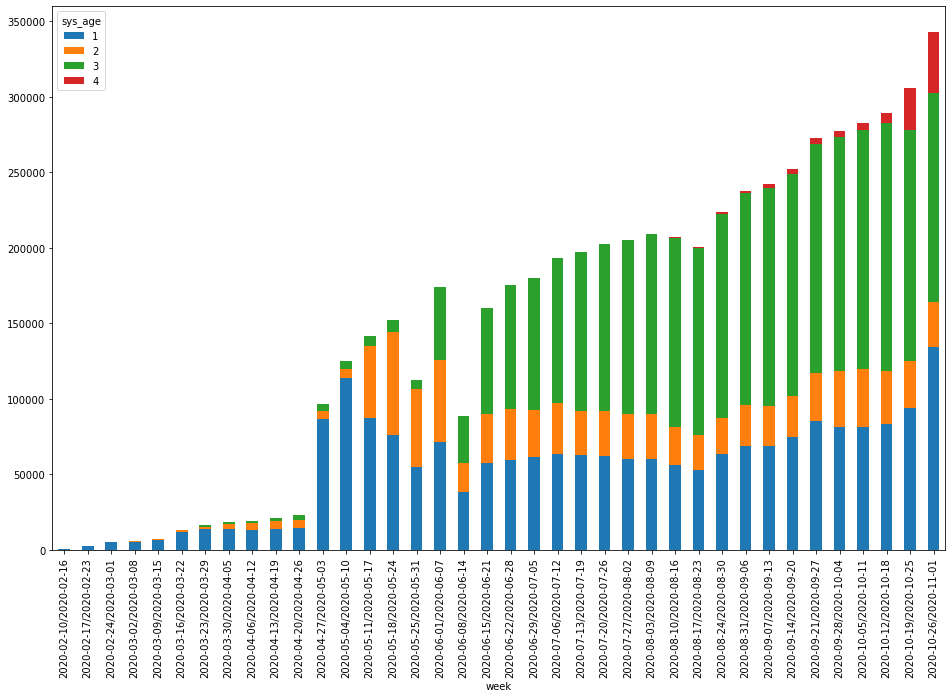

In [20]:
# If you give `columns`, you'll get a stacked bar plot.
# So if you wanted that plot with each bar split by sys_age:
(
    host_totals
    .pivot_table(index='week', values='hosts', aggfunc='sum', columns='sys_age')
    .plot.bar(stacked=True, figsize=(16,10))
)

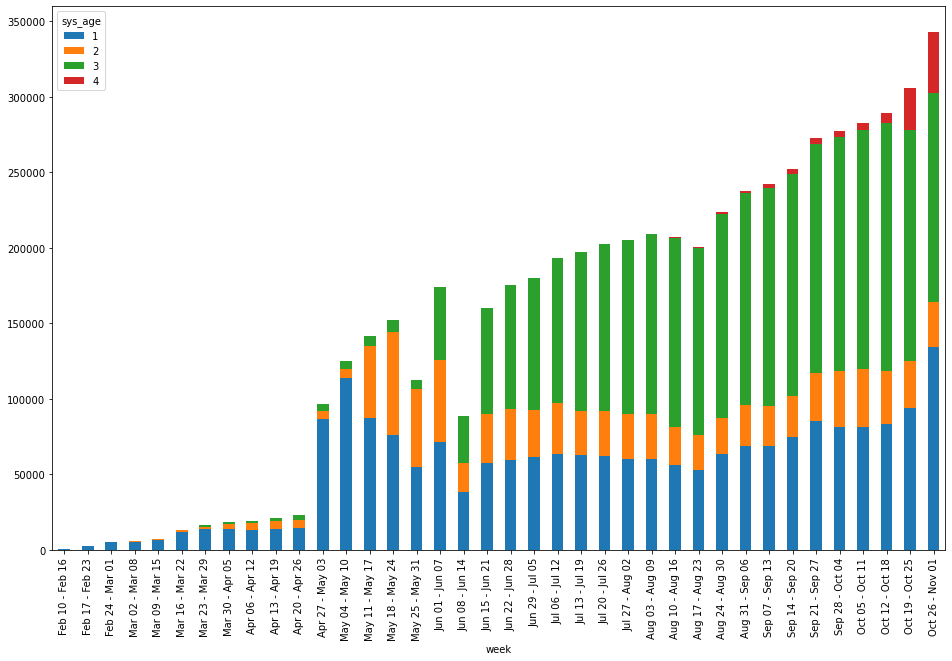

In [21]:
# Formatting the weekly labels is kinda tricky, because pandas drops the actual dates from the
# axis when it plots a PeriodIndex in a bar graph, so matplotlib tick locators/formatters
# won't work as expected. You can pretty easily change the labels, though.

pv = host_totals.pivot_table(index='week', values='hosts', aggfunc='sum', columns='sys_age')
ax = pv.plot.bar(stacked=True, figsize=(16,10))
                 
# New labels - just a list of strings, one per item in the index.
# Period objects have .start_time and .end_time attributes, which are datetimes
# and support the fancy strftime formatting. So this gives us date ranges like:
#     Mar 23 - Mar 29
#     Mar 30 - Apr 05
# etc.
weeklabels = [f"{p.start_time:%b %d} - {p.end_time:%b %d}" for p in pv.index]
ax.xaxis.set_ticklabels(weeklabels)
plt.show()

<AxesSubplot:title={'center':'OS Variant, all clients\n(2020-02-10 - 2020-11-01)'}, ylabel='hosts'>

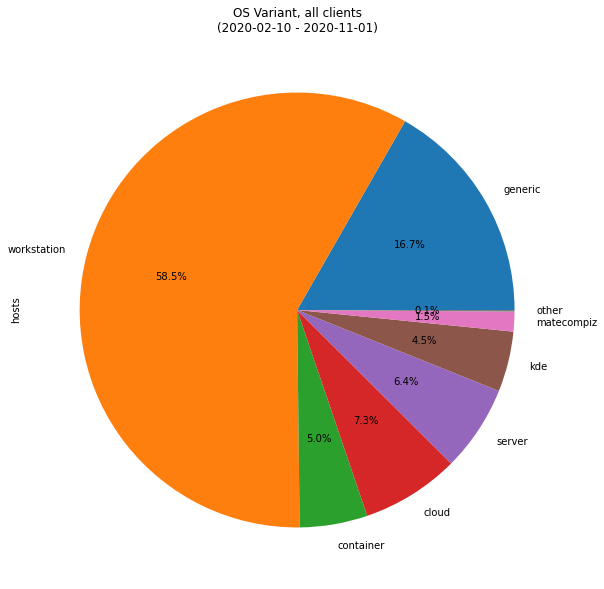

In [22]:
# Here's a handy function to trim down a categorically-indexed series by merging
# small values into an "other" item.
def condense_cat(series, min_pct=1.0, cat_name='other'):
    small = series/series.sum()*100 < min_pct # Make a row mask for small values
    condensed = series[~small]                # Take all the not-small values
    condensed.index = condensed.index.add_categories(cat_name)
    condensed.loc[cat_name] = series[small].sum() # Add the sum of the small values
    return condensed

# Another helper, to give the date range of an index..
def period_range(period_index):
    return period_index.min().start_time, period_index.max().end_time
start, end = period_range(week_index)


condense_cat(
    host_totals
    .pivot_table(index='os_variant', values='hosts', aggfunc='sum', fill_value=0, observed=True)
    ['hosts']
).plot.pie(title=f"OS Variant, all clients\n({start:%Y-%m-%d} - {end:%Y-%m-%d})",
           figsize=(10,10), autopct='%1.1f%%')
